# Miscellaneous



In [1]:
# setup notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import figanos.matplotlib as fg
from matplotlib import pyplot as plt
import numpy as np
import xsdba
import xclim as xc

fg.utils.set_mpl_style("ouranos")

# load dataset
url = "https://pavics.ouranos.ca//twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/cccs_portal/indices/Final/BCCAQv2_CMIP6/tx_max/YS/ssp585/ensemble_percentiles/tx_max_ann_BCCAQ2v2+ANUSPLIN300_historical+ssp585_1950-2100_30ymean_percentiles.nc"
opened = xr.open_dataset(url, decode_timedelta=False)
ds_time = opened.isel(lon=500, lat=250)[["tx_max_p50", "tx_max_p10", "tx_max_p90"]]

## Climate Stripes

Climate stripe diagrams are a way to present the relative change of climate variables or indicators over time, in a simple and aesthetically-pleasing manner. Figanos creates such plots through the stripes function.

While the vast majority of these diagrams will show the yearly change of a variable relative to a reference point, `stripes()` will adjust the size of the stripes to fill the figure to accommodate datasets with time intervals greater than a year.

The function accepts DataArrays, one-variable Datasets, and a dictionary containing scenarios (DataArrays or Datasets) to be stacked. The plot will be divided in as many sub-axes as there are entries in the dictionary. Normally, these scenarios would contain identical data up to a certain year, where the scenarios diverge; the `divide` argument should be used to create an axis separation at this point of divergence.

<Axes: >

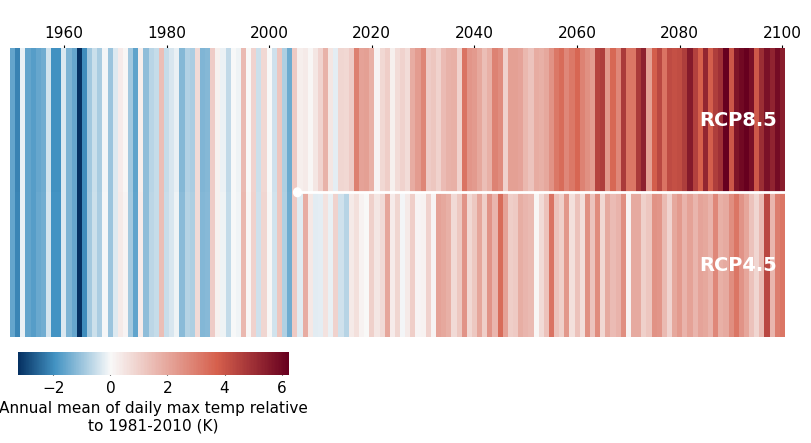

In [3]:
# Create two datasets of mean annual temperature relative to the 1981-2010 period
url1 = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/portraits-clim-1.3/MPI-ESM-LR_rcp85_tx_mean_annual.nc"
rcp85 = xr.open_dataset(url1, decode_timedelta=False)
rcp85 = rcp85.sel(lon=-73, lat=46, method="nearest")
rcp85_deltas = rcp85 - rcp85.sel(time=slice("1981", "2010")).mean(dim="time")
rcp85_deltas.tx_mean_annual.attrs["long_name"] = "Mean annual daily max temp relative to 1981-2010"
rcp85_deltas.tx_mean_annual.attrs["units"] = "K"

url2 = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/portraits-clim-1.3/MPI-ESM-LR_rcp45_tx_mean_annual.nc"
rcp45 = xr.open_dataset(url2, decode_timedelta=False)
rcp45 = rcp45.sel(lon=-73, lat=46, method="nearest")
rcp45_deltas = rcp45 - rcp45.sel(time=slice("1981", "2010")).mean(dim="time")
rcp45_deltas.tx_mean_annual.attrs["long_name"] = "Annual mean of daily max temp relative to 1981-2010"
rcp45_deltas.tx_mean_annual.attrs["units"] = "K"

# Plot
fg.stripes({"rcp45": rcp45_deltas, "rcp85": rcp85_deltas}, divide=2006)

# plt.savefig("images/stripes.png", bbox_inches='tight')

Like most of the other functions, `stripes()` will attempt to find a colormap that is appropriate for the data variables.

Text(0.5, 1.0, 'Precipitation')

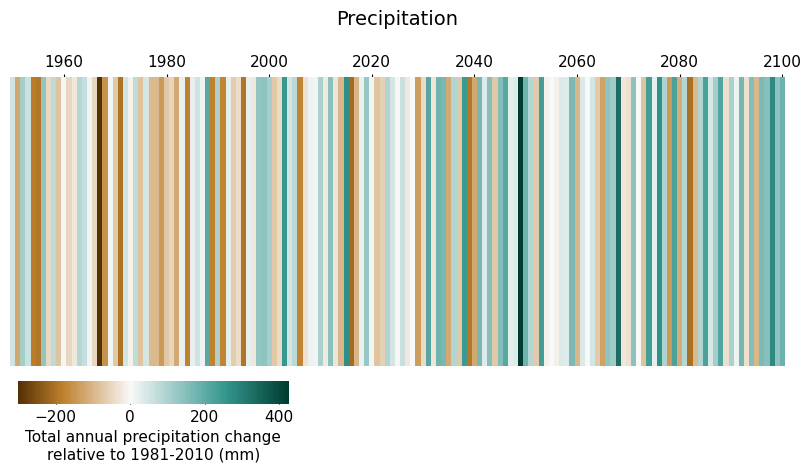

In [4]:
# Create a similar dataset with precipitation data
url3 = (
    "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/portraits-clim-1.3/MPI-ESM-LR_rcp85_precip_accumulation_annual.nc"
)
prec = xr.open_dataset(url3, decode_timedelta=False)
prec = prec.sel(lon=-73, lat=46, method="nearest")
prec_deltas = prec - prec.sel(time=slice("1981", "2010")).mean(dim="time")
prec_deltas.precip_accumulation_annual.attrs["long_name"] = "Total annual precipitation change relative to 1981-2010"
prec_deltas.precip_accumulation_annual.attrs["units"] = "mm"

ax = fg.stripes(prec_deltas)
ax.set_title("Precipitation")

## Violin Plots

Violin plots are a practical tool for visualizing the statistical distribution of data in an ensemble, combining a box plot with a kernel density plot. The violin function wraps Seaborn's [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot) function to directly accept xarray objects, and incorporates other figanos features. The `data` argument can be a DataArray (one "violin"), a Dataset (as many "violins" as there are variables in the Dataset), or a dictionary of either types. In the case of a dictionary, its keys will become the "violin" labels.

As with other functions, when `use_attrs` is passed and `data` is a dictionary, attributes from the first dictionary entry will be put on the plot.

<Axes: title={'left': '30 year mean Annual maximum of daily maximum\ntemperature. 50th percentile of ensemble.'}, ylabel='30 year mean Maximum daily\nmaximum temperature (K)'>

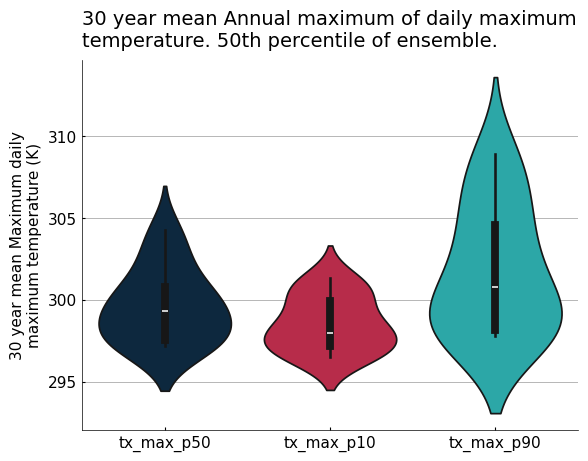

In [5]:
fg.violin(ds_time, use_attrs={"title": "description"})

In [6]:
# plt.savefig("images/violin.png", bbox_inches='tight')

The optional `color` argument combines the Seaborn function's `color` and `palette` arguments. A single color or a list of colors can be passed. Integers can be passed instead of strings to refer to colors of the currently used stylesheet. If the list of colors is shorter than the number of variables on the plot, the colors are repeated.

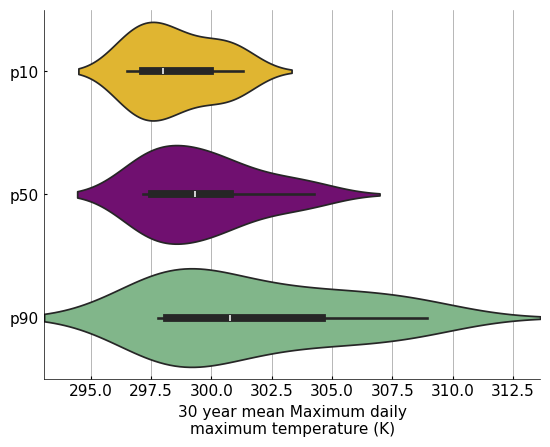

In [7]:
my_data = {
    "p10": ds_time.tx_max_p10,
    "p50": ds_time.tx_max_p50,
    "p90": ds_time.tx_max_p90,
}

ax = fg.violin(my_data, plot_kw={"orient": "h"}, color=[3, "purple", "#78bf84"])

## Heatmaps

Similarly to violin plots, the heatmap function wraps Seaborn's [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to directly accept xarray objects, and incorporates other figanos features. The `data` argument can be a DataArray, a Dataset, or a dictionary of either types and of `length=1`. There is no real benefit to using a dictionary, but it is accepted in order to be coherent with other functions in the package.

<Axes: xlabel='properties', ylabel='realization'>

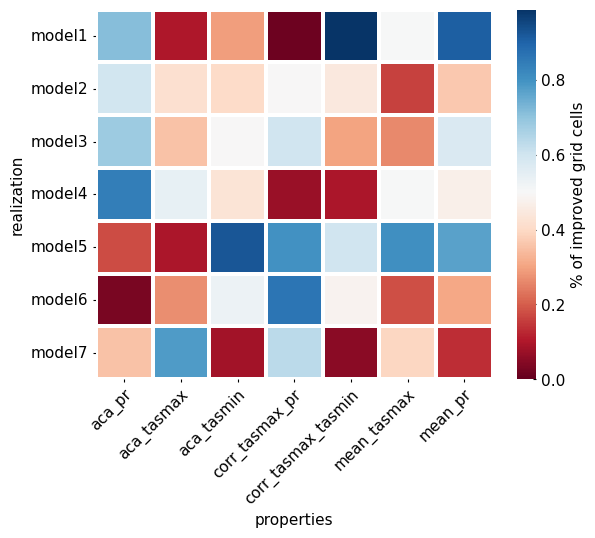

In [8]:
# Create a diagnostics Dataset from scratch
improvement = np.random.rand(7, 7)
diagnostics = xr.DataArray(
    data=improvement,
    coords=dict(
        realization=[
            "model1",
            "model2",
            "model3",
            "model4",
            "model5",
            "model6",
            "model7",
        ],
        properties=[
            "aca_pr",
            "aca_tasmax",
            "aca_tasmin",
            "corr_tasmax_pr",
            "corr_tasmax_tasmin",
            "mean_tasmax",
            "mean_pr",
        ],
    ),
)

diagnostics.attrs["long_name"] = "% of improved grid cells"

# Plot a heatmap
fg.heatmap(
    diagnostics,
    divergent=0.5,
    plot_kw={"vmin": 0, "linecolor": "w", "linewidth": 1.5},
)

In order to produce reliable results, the xarray object passed to `heatmap()` has to have only two dimensions. Under the hood, the function converts the DataArray containing the data to a pandas DataFrame before plotting it. Using `transpose=True` swaps the `x` and `y` axes.

The colorbar kwargs are accessible through the nesting of `cbar_kws` in `plot_kw`.

Text(53.380208333333314, 0.5, '')

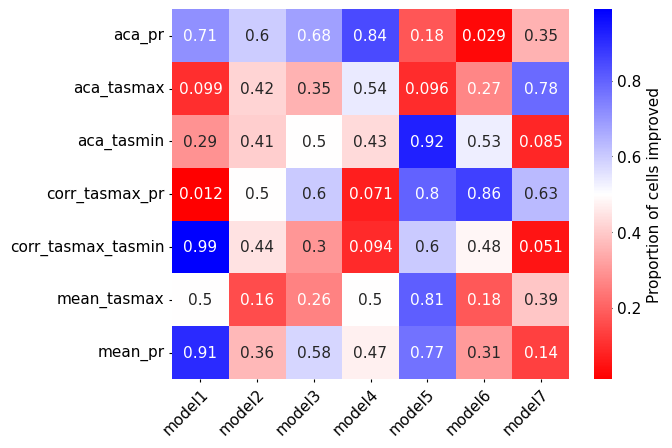

In [9]:
ax = fg.heatmap(
    diagnostics,
    transpose=True,
    cmap="bwr_r",
    divergent=0.5,
    plot_kw={
        "cbar_kws": {"label": "Proportion of cells improved"},
        "annot": True,
    },
)

# Remove the grid labels
ax.set_xlabel("")
ax.set_ylabel("")

In [10]:
# plt.savefig("images/heatmap.png", bbox_inches='tight')

## Triangle Heatmaps

The `triheatmap` function is based on the matplotlib function [tripcolor](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tripcolor.html). It can create a heatmap with 2 or 4 triangles in each square of the heatmap.


/exec/scgoulet/figanos/src/figanos/matplotlib/utils.py:228: UserWarning: Attribute "None" not found.
  warnings.warn(f'Attribute "{string}" not found.')


<Axes: xlabel='realization', ylabel='method'>

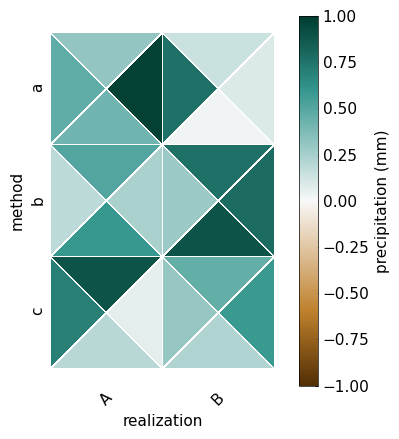

In [11]:
# Create a fake data
da = xr.DataArray(
    data=np.random.rand(2, 3, 4),
    coords=dict(
        realization=["A", "B"],
        method=["a", "b", "c"],
        experiment=["ssp126", "ssp245", "ssp370", "ssp585"],
    ),
)
da.name = "pr"  # to guess the cmap
# will be automatically detected for the cbar label
da.attrs["long_name"] = "precipitation"
da.attrs["units"] = "mm"

# Plot a heatmap
fg.triheatmap(
    da,
    z="experiment",  # which dimension should be represented by triangles
    divergent=True,  # for the cmap
    cbar="unique",  # only show one cbar
    plot_kw={
        "vmin": -1,
        "vmax": 1,
    },  # we are only showing the 1st cbar, so make sure the cbar of each triangle is the same
)

In [12]:
# plt.savefig("images/triangle1.png", bbox_inches='tight')

/exec/scgoulet/figanos/src/figanos/matplotlib/utils.py:879: UserWarning: Colormap warning: Variable group not found. Use the cmap argument.
  warnings.warn(
/exec/scgoulet/figanos/src/figanos/matplotlib/utils.py:228: UserWarning: Attribute "units" not found.
  warnings.warn(f'Attribute "{string}" not found.')
/exec/scgoulet/figanos/src/figanos/matplotlib/utils.py:228: UserWarning: Attribute "long_name" not found.
  warnings.warn(f'Attribute "{string}" not found.')


<Axes: title={'center': 'La plus belle saison de ma vie'}, xlabel='realization', ylabel='method'>

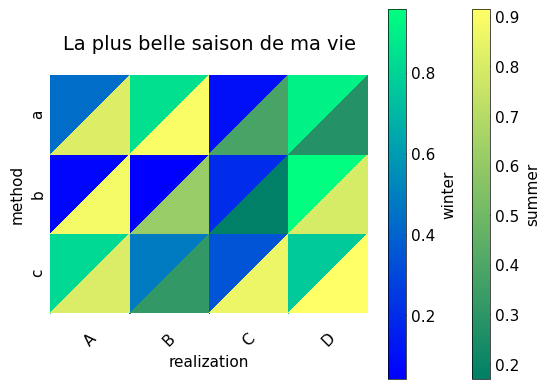

In [13]:
# Create a fake data
da = xr.DataArray(
    data=np.random.rand(4, 3, 2),
    coords=dict(
        realization=["A", "B", "C", "D"],
        method=["a", "b", "c"],
        season=["DJF", "JJA"],
    ),
)
da.attrs["description"] = "La plus belle saison de ma vie"

# Plot a heatmap
fg.triheatmap(
    da,
    z="season",
    cbar="each",  # show a cbar per triangle
    use_attrs={"title": "description"},
    cbar_kw=[
        {"label": "winter"},
        {"label": "summer"},
    ],  # Use a list to change the cbar associated with each triangle type (upper or lower)
    plot_kw=[{"cmap": "winter"}, {"cmap": "summer"}],
)  # Use a list to change each triangle type (upper or lower)

In [14]:
# plt.savefig("images/triangle2.png", bbox_inches='tight')

## Taylor Diagrams

Taylor diagrams are a useful way to compare simulation datasets to a reference dataset. They allow for graphical representation of the standard deviation of both the simulation and reference datasets, the correlation between both, and the root mean squared error (a function of the two previous statistical properties).

The `taylordiagram()` function creates each point on the Taylor diagram from an object created using `xsdba.measures.taylordiagram`, as illustrated below.

### Important Notes
* The structure of the matplotlib axes being different from the other figanos functions, this function does not have an `ax` argument, and creates its own figure.
* To change the axis labels, use the `std_label` and `corr_label` arguments, rather than the `ax.set_xlabel()` method.
* Dataset with negative correlations with the reference dataset will not be plotted.
* To modify the appearance of the reference point (on the `x`-axis), use the keyword 'reference' in `plot_kw`.

(<Figure size 640x480 with 1 Axes>,
 <FloatingAxesHostAxes: >,
 <matplotlib.legend.Legend at 0x7ff298204d70>)

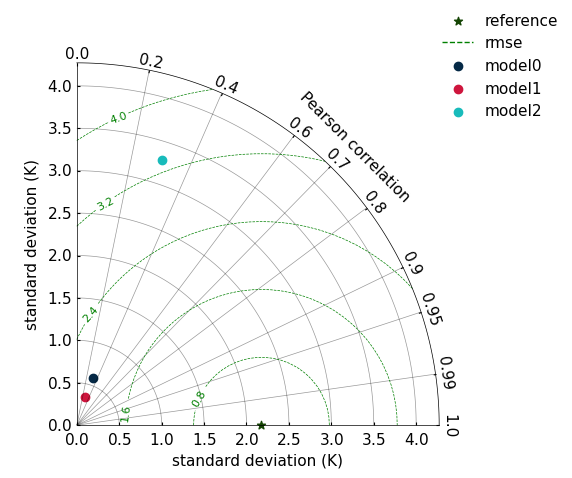

In [15]:
da_ref = ds_time["tx_max_p50"]

# Toy data with same mean as `da_ref` & modify deviations with trigonometric functions
homogenous_ref_mean = xr.full_like(da_ref, da_ref.mean(dim="time"))
simd = {}
for i, f_trig in enumerate([np.cos, lambda x: np.cos(x) ** 2, np.tan]):
    da = homogenous_ref_mean + f_trig(da_ref.values)
    da.attrs["units"] = da_ref.attrs["units"]
    simd[f"model{i}"] = xsdba.measures.taylordiagram(sim=da, ref=da_ref)

fg.taylordiagram(
    simd,
    std_range=(0, 1.3),
    contours=5,
    contours_kw={"colors": "green"},
    plot_kw={"reference": {"marker": "*"}},
)

In [16]:
# plt.savefig("images/taylor.png", bbox_inches='tight')

### Normalized Taylor Diagram

If we normalize the standard deviation of our measures, many Taylor diagrams with difference references can be combined in a single plot. In the following example, we have datasets with two variables (`tasmax, pr`) and three location coordinates. For each location (3) and variable (2), a `taylordiagram` measure is computed. Each set of correlation and standard deviation is then plotted.

(<Figure size 640x480 with 1 Axes>,
 <FloatingAxesHostAxes: >,
 <matplotlib.legend.Legend at 0x7ff28abf25d0>)

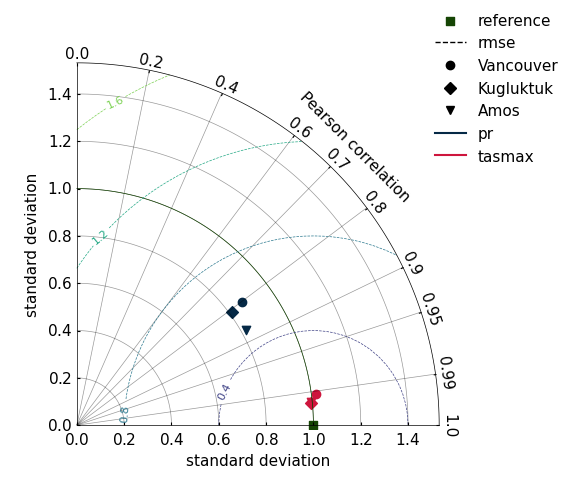

In [17]:
from xclim.testing.utils import nimbus
import pooch  # FIXME: remove downloader when xclim fixes the issue with nimbus
from figanos import __version__ as __figanos_version__

downloader = pooch.HTTPDownloader(headers={"User-Agent": f"figanos {__figanos_version__}"})
n = nimbus()

ref = n.fetch("sdba/ahccd_1950-2013.nc", downloader=downloader)
ds_ref = xr.open_dataset(ref)
sim = n.fetch("sdba/nrcan_1950-2013.nc", downloader=downloader)
ds_sim = xr.open_dataset(sim)

for v in ds_ref.data_vars:
    ds_sim[v] = xc.core.units.convert_units_to(ds_sim[v], ds_ref[v], context="hydro")

# Here, we have three locations, two variables. We stack variables to convert from
# a Dataset to a DataArray.
da_ref = xsdba.stack_variables(ds_ref)
da_sim = xsdba.stack_variables(ds_sim)

# Each location/variable will have its own set of taylor parameters
out = xsdba.measures.taylordiagram(ref=da_ref, sim=da_sim, dim="time")

# If we normalize the taylor diagrams, they can be compared on the same plot
out[{"taylor_param": [0, 1]}] = out[{"taylor_param": [0, 1]}] / out[{"taylor_param": 0}]

# in xclim >= 0.50.0 : Normalization can be done when computing taylordiagram measure
# out = sdba.measures.taylordiagram(ref=da_ref, sim=da_sim, dim="time", normalize=True)

# The `markers_key` and `colors_key` are used to separate between two different features.
# Here, the type of marker is used to distinguish between locations, and the color
# distinguishes between variables. If those parameters are not specified, then each
# pair (location, multivar)  has simply its own color.
fg.taylordiagram(out, markers_key="location", colors_key="multivar", ref_std_line=True)

## Partition Plots

Partition plots show the fraction of uncertainty associated with different components.
Xclim has a few different [partition functions](https://xclim.readthedocs.io/en/stable/api.html#uncertainty-partitioning).

This tutorial is a reproduction of [xclim's documentation](https://xclim.readthedocs.io/en/stable/notebooks/partitioning.html).

<div class="alert alert-info">

Note that you could also use the [xscen library](https://xscen.readthedocs.io/en/latest/index.html) to build and ensemble from a catalog with `xscen.ensembles.build_partition_data`.

</div>

In [18]:
# Fetch data
import pandas as pd

import xclim.ensembles

# The directory in the Atlas repo where the data is stored
# host = "https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP6/CMIP6_tas_land/"
host = "https://raw.githubusercontent.com/IPCC-WG1/Atlas/main/datasets-aggregated-regionally/data/CMIP6/CMIP6_tas_land/"

# The file pattern, e.g. CMIP6_ACCESS-CM2_ssp245_r1i1p1f1.csv
pat = "CMIP6_{model}_{scenario}_{member}.csv"

# Here we'll download data only for a very small demo sample of models and scenarios.

# Download data for a few models and scenarios.
models = ["ACCESS-CM2", "CMCC-CM2-SR5", "CanESM5"]
members = ["r1i1p1f1", "r1i1p1f1", "r1i1p1f1"]
scenarios = ["ssp245", "ssp370", "ssp585"]

# Create the input ensemble.
data = []
for model, member in zip(models, members):
    for scenario in scenarios:
        url = host + pat.format(model=model, scenario=scenario, member=member)

        # Fetch data using pandas
        df = pd.read_csv(url, index_col=0, comment="#", parse_dates=True)["world"]
        # Convert to a DataArray, complete with coordinates.
        da = xr.DataArray(df).expand_dims(model=[model], scenario=[scenario]).rename(date="time")
        data.append(da)

# Combine DataArrays from the different models and scenarios into one.
ens_mon = xr.combine_by_coords(data)["world"]

# Then resample the monthly time series at the annual frequency
ens = ens_mon.resample(time="Y").mean()

/exec/scgoulet/.conda/figanos/lib/python3.13/site-packages/xarray/groupers.py:498: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Compute uncertainties with xclim and use `fractional_uncertainty` to have the right format to plot.

In [19]:
# compute uncertainty
mean, uncertainties = xclim.ensembles.hawkins_sutton(ens, baseline=("2016", "2030"))


# frac= xc.ensembles.fractional_uncertainty(uncertainties)


# FIXME: xc.ensembles.fractional_uncertainty has not been released yet. Until until it is released, here it is.
def fractional_uncertainty(u: xr.DataArray):
    """Return the fractional uncertainty.

    Parameters
    ----------
    u : xr.DataArray
        Array with uncertainty components along the `uncertainty` dimension.

    Returns
    -------
    xr.DataArray
        Fractional, or relative uncertainty with respect to the total uncertainty.
    """
    uncertainty = u / u.sel(uncertainty="total") * 100
    uncertainty.attrs.update(u.attrs)
    uncertainty.attrs["long_name"] = "Fraction of total variance"
    uncertainty.attrs["units"] = "%"
    return uncertainty


frac = fractional_uncertainty(uncertainties)

<Axes: xlabel='Lead time (years from 2016)', ylabel='Fraction of total variance (%)'>

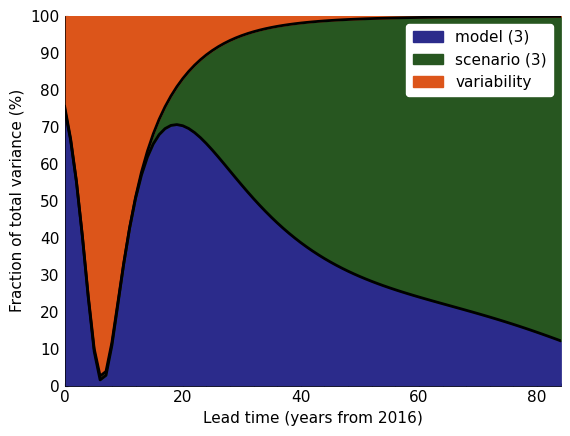

In [20]:
# plot
fg.partition(
    frac,
    start_year="2016",  # change the x-axis
    show_num=True,  # put the number of element of each uncertainty source in the legend FIXME: will only appear after xclim releases 0.48
    fill_kw={
        "variability": {"color": "#DC551A"},
        "model": {"color": "#2B2B8B"},
        "scenario": {"color": "#275620"},
    },
    line_kw={"lw": 2},
)

In [21]:
# plt.savefig("images/partition.png", bbox_inches='tight')

## Logos

Logos can also be added to plots if desired using the `figanos.utils.plot_logo()` function. This function requires that logos are passed as `pathlib.Path()` objects or installed and called by their name (as `str`).

Figanos offers the `Logos()` convenience class for setup and management of logos so that they can be reused as needed. Logos can be used to set default logos as well as install custom logos, if desired. Logo files are saved to the user's config folder so that they can be reused.

By default, the `figanos_logo.png` is installed on initialization, while the Ouranos set of logos can be installed if desired.

For more information on logos, see the Logos documentation.


In [22]:
from figanos import Logos

# Installing the default logos
logos = Logos()
print(f"Default logo is found at: {logos.default}.")

# Installing the Ouranos logos
logos.install_ouranos_logos(permitted=True)

# Show all installed logos
logos.installed()

Default logo is found at: /home/scgoulet/.config/figanos/logos/logo-ouranos-horizontal-couleur.svg.
Ouranos logos installed at: /home/scgoulet/.config/figanos/logos.


['default',
 'figanos_logo',
 'logo_ouranos_horizontal_blanc',
 'logo_ouranos_horizontal_couleur',
 'logo_ouranos_horizontal_noir',
 'logo_ouranos_vertical_blanc',
 'logo_ouranos_vertical_couleur',
 'logo_ouranos_vertical_noir',
 'my_custom_logo']

In [23]:
# To set a new default logo we can simply use an existing entry
logos.set_logo(logos.logo_ouranos_horizontal_couleur, "default")
print(f"Default logo is found at: {logos.default}")
logos.set_logo(logos.logo_ouranos_vertical_couleur, "my_custom_logo")
print(f"my_custom_logo installed at: {logos.my_custom_logo}.")

# Show all installed logos
logos.installed()

Default logo is found at: /home/scgoulet/.config/figanos/logos/logo-ouranos-horizontal-couleur.svg
my_custom_logo installed at: /home/scgoulet/.config/figanos/logos/logo-ouranos-vertical-couleur.svg.


['default',
 'figanos_logo',
 'logo_ouranos_horizontal_blanc',
 'logo_ouranos_horizontal_couleur',
 'logo_ouranos_horizontal_noir',
 'logo_ouranos_vertical_blanc',
 'logo_ouranos_vertical_couleur',
 'logo_ouranos_vertical_noir',
 'my_custom_logo']

<Axes: title={'left': '30 year mean Annual maximum of daily maximum\ntemperature. 10th percentile of ensemble.'}, xlabel='Time', ylabel='30 year mean Maximum daily\nmaximum temperature (K)'>

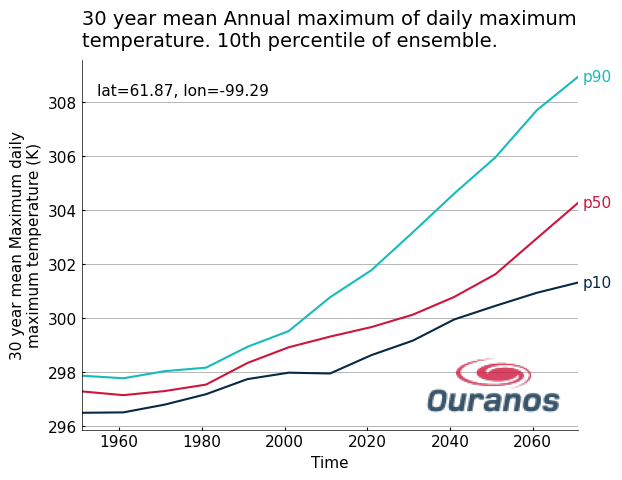

In [24]:
ax = fg.timeseries(my_data, show_lat_lon="upper left", legend="edge")

# Plotting with the default logo
# fg.utils.plot_logo(ax, loc='lower right', alpha=0.8, width=120)

# Plotting with a custom logo, resized with pixels
fg.utils.plot_logo(
    ax,
    logo="my_custom_logo",
    loc="lower right",
    width=100,
    alpha=0.8,
)

In [25]:
# plt.savefig("images/logo.png", bbox_inches='tight')